In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
plt.rcParams['figure.figsize'] = [15,11]

In [2]:
from CRUD import *
connection = connectToDatabase("./data/ikon_clean.db")

In [3]:
artists_count = connection.execute("SELECT Count(*) FROM artists").fetchone()[0]
exhibitions_count = connection.execute("SELECT Count(*) FROM exhibitions").fetchone()[0]
galleries_count = connection.execute("SELECT Count(*) FROM galleries").fetchone()[0]

print("ikon sql statistics")
print("artists:\t", artists_count) 
print("exhibitions:\t",exhibitions_count) 
print("galleries:\t",galleries_count)


ikon sql statistics
artists:	 14970
exhibitions:	 14872
galleries:	 420


# Search

In [4]:
# Search whole database

import ipywidgets as widgets
from IPython.display import display, HTML
from ipywidgets import interact

sql_artist = '''
SELECT DISTINCT a.name FROM artists_exhibitions ae
JOIN artists a ON a.id = ae.artist_id
JOIN exhibitions e on e.id = ae.exhibition_id
JOIN galleries g ON g.id = e.gallery_id
WHERE e.title LIKE ?
AND a.name LIKE ?
AND g.name LIKE ?
'''

sql_gallery = '''
SELECT DISTINCT g.name FROM artists_exhibitions ae
JOIN artists a ON a.id = ae.artist_id
JOIN exhibitions e on e.id = ae.exhibition_id
JOIN galleries g ON g.id = e.gallery_id
WHERE e.title LIKE ?
AND a.name LIKE ?
AND g.name LIKE ?
'''

sql_exhibition = '''
SELECT DISTINCT e.title FROM artists_exhibitions ae
JOIN artists a ON a.id = ae.artist_id
JOIN exhibitions e on e.id = ae.exhibition_id
JOIN galleries g ON g.id = e.gallery_id
WHERE e.title LIKE ?
AND a.name LIKE ?
AND g.name LIKE ?
'''

@interact
def search(artist="%%", exhibition="%%", gallery="%%"):
    artists = connection.execute(sql_artist, (exhibition, artist, gallery)).fetchall()
    exhibitions = connection.execute(sql_exhibition, (exhibition, artist, gallery)).fetchall()
    galleries = connection.execute(sql_gallery, (exhibition, artist, gallery)).fetchall()
    
    artistsWidget = widgets.Output()
    with artistsWidget:
        display(pd.DataFrame(artists))
        
    exhibitionsWidget = widgets.Output()
    with exhibitionsWidget:
        display(pd.DataFrame(exhibitions))
        
    galleriesWidget = widgets.Output()
    with galleriesWidget:
        display(pd.DataFrame(galleries))
    

    return widgets.HBox([
        artistsWidget, exhibitionsWidget, galleriesWidget
    ])

interactive(children=(Text(value='%%', description='artist'), Text(value='%%', description='exhibition'), Text…

In [11]:
# Search artists

import ipywidgets as widgets
from IPython.display import display, HTML
from ipywidgets import interact

sql = '''
SELECT a.id, a.name, COUNT(ae.artist_id) as No_exhibitions
FROM artists_exhibitions ae
JOIN artists a ON a.id = ae.artist_id
WHERE a.name LIKE ?
GROUP BY ae.artist_id
ORDER BY No_exhibitions DESC;
'''

@interact
def showArtists(artist="%%"):
    data = connection.execute(sql, (artist.lower(), )).fetchall()
    for idx, row in enumerate(data[:20]):
        print(idx+1, row[1], row[2])
    #df = pd.DataFrame( data, columns= ["id", "name", "no exhibitions"])
    #display(df)



interactive(children=(Text(value='%%', description='artist'), Output()), _dom_classes=('widget-interact',))

In [39]:
# Search exhibitions

import ipywidgets as widgets
from IPython.display import display, HTML
from ipywidgets import interact

sql = '''
SELECT title, date
FROM exhibitions ae
WHERE title LIKE ?
ORDER BY date DESC;
'''

@interact
def showArtists(artist="%%"):
    df = pd.DataFrame( connection.execute(sql, (artist.lower(), )).fetchall(), columns= ["title", "date"])
    display(df)

interactive(children=(Text(value='%%', description='artist'), Output()), _dom_classes=('widget-interact',))

# Analyze

<BarContainer object of 14970 artists>

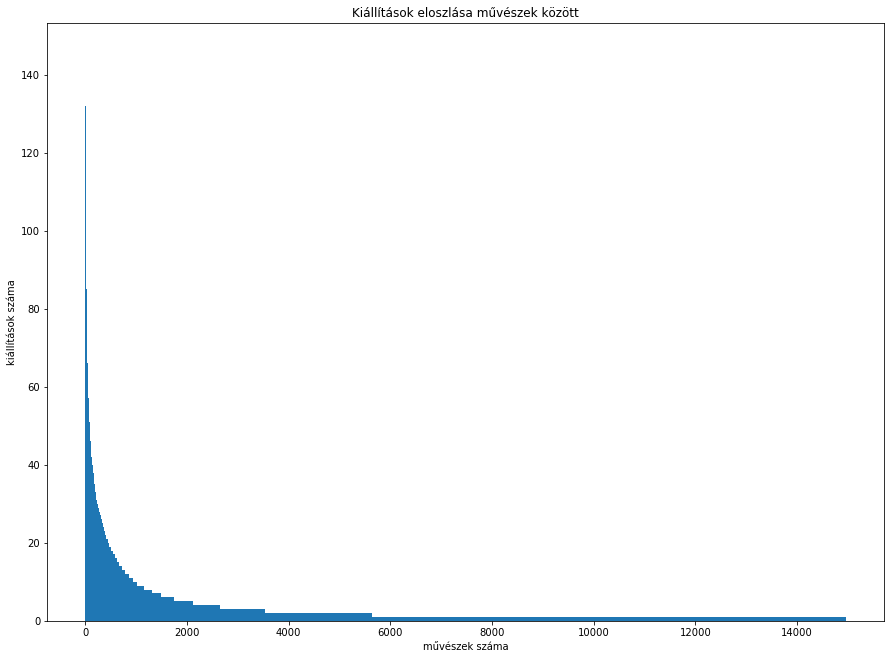

In [40]:
# exhibition distribution amoung artists
sql = '''
SELECT COUNT(ae.artist_id) as c
FROM artists_exhibitions ae
JOIN artists a ON a.id = ae.artist_id
GROUP BY ae.artist_id
ORDER BY c DESC;
'''
counts = np.array([r[0] for r in connection.execute(sql).fetchall()])

# create figure
plt.ylabel("kiállítások száma")
plt.xlabel("művészek száma")
plt.title("Kiállítások eloszlása művészek között")
plt.bar(np.arange(len(counts)), counts, width=1.0)

<BarContainer object of 7 artists>

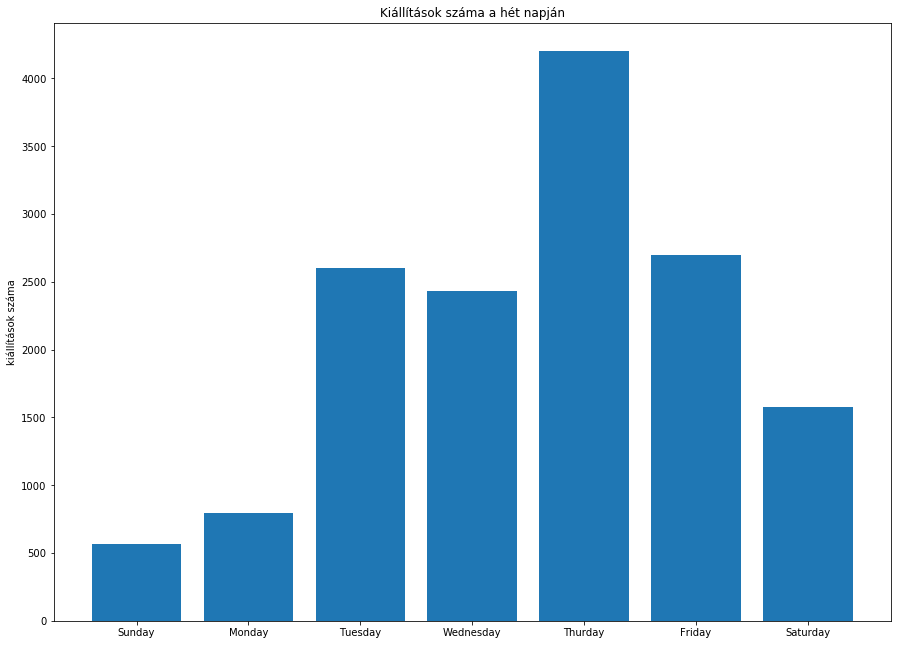

In [101]:
# exhibitions distributiűon amoung weekdays
sql = '''
SELECT strftime("%w", date), COUNT(*)
FROM exhibitions
GROUP BY strftime("%w", date)
'''
data = connection.execute(sql).fetchall()
counts = [r[1] for r in data]
labels = ["Sunday","Monday","Tuesday","Wednesday","Thurday","Friday","Saturday"]
plt.ylabel("kiállítások száma")
plt.title("Kiállítások száma a hét napján")
plt.bar(labels, counts)

<BarContainer object of 7 artists>

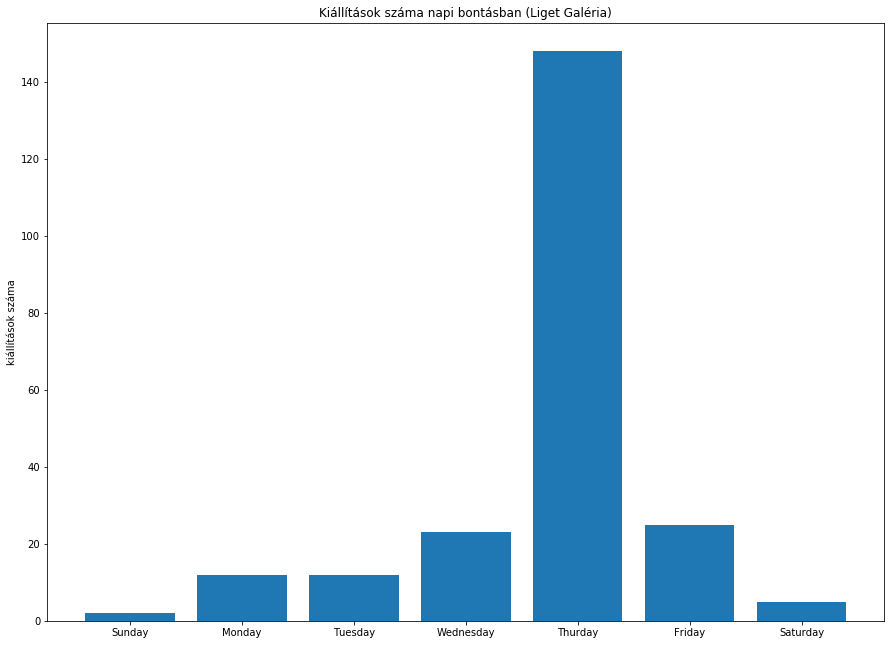

In [122]:
# usual opening day at Kisterem
from collections import Counter
sql = '''
SELECT strftime("%w", date), COUNT(*)
FROM exhibitions AS e
JOIN galleries g ON g.id = e.gallery_id
WHERE g.name LIKE ?
GROUP BY strftime("%w", e.date)
'''
data = connection.execute(sql, ("Liget%", )).fetchall()
days = ["Sunday","Monday","Tuesday","Wednesday","Thurday","Friday","Saturday"]
counter = Counter({"Sunday": 0,"Monday": 0,"Tuesday": 0,"Wednesday": 0,"Thurday": 0,"Friday": 0,"Saturday": 0})
for row in data:
    day = days[int(row[0])]
    count = row[1]
    counter[day]+=count

# plot
plt.title("Kiállítások száma napi bontásban (Liget Galéria)")
plt.ylabel("kiállítások száma")
plt.bar(counter.keys(), counter.values())
    
    

<BarContainer object of 12 artists>

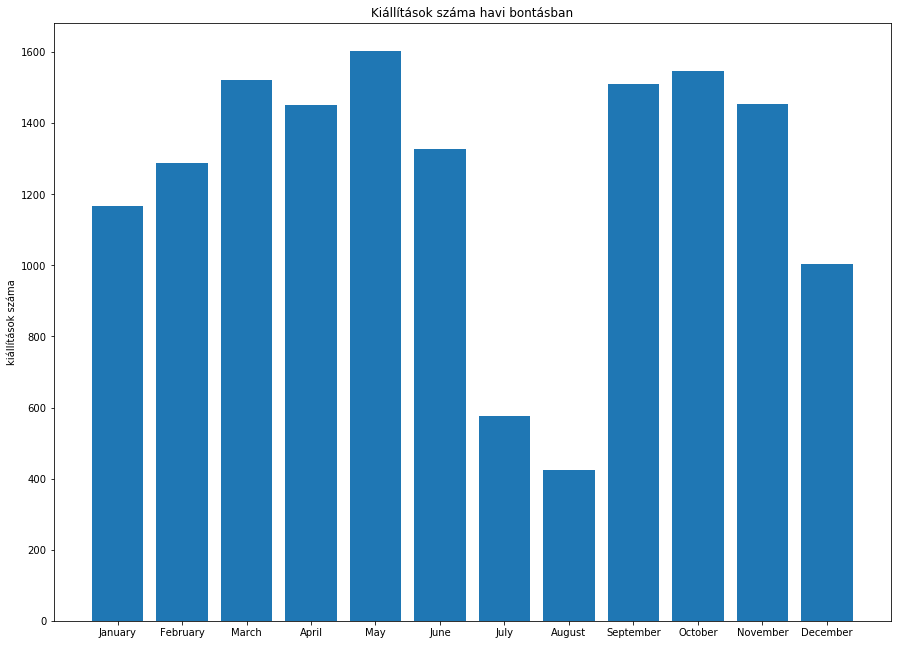

In [41]:
# exhibitions distribution amoung months
sql = '''
SELECT strftime("%m", date), COUNT(*)
FROM exhibitions
GROUP BY strftime("%m", date)
'''
import datetime
labels = [r[0] for r in connection.execute(sql).fetchall()]
labels = [datetime.date(2020,int(month),1).strftime("%B") for month in labels]
counts = [r[1] for r in connection.execute(sql).fetchall()]

plt.title("Kiállítások száma havi bontásban")
plt.ylabel("kiállítások száma")
plt.bar(labels, counts)

<BarContainer object of 22 artists>

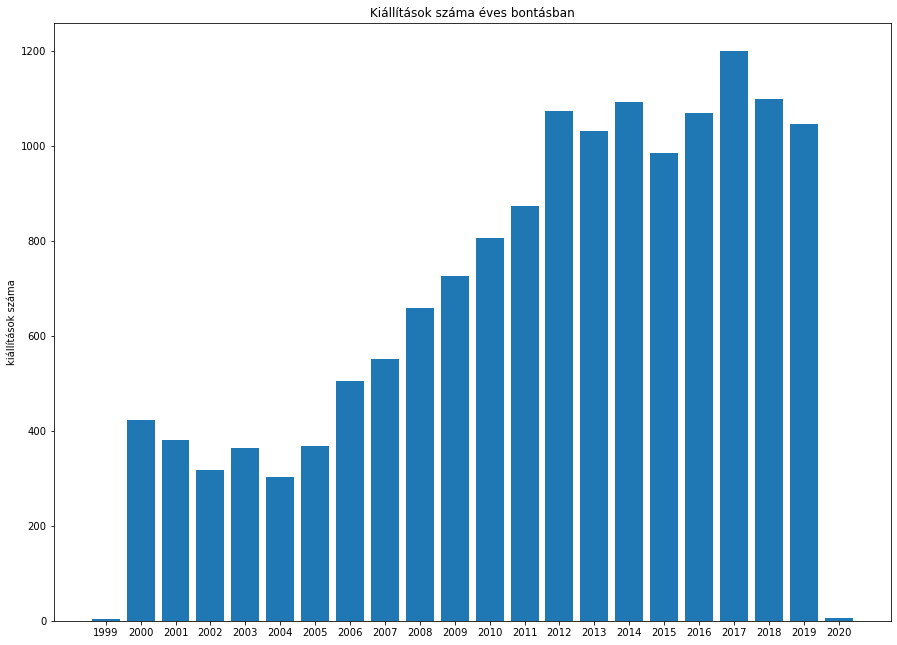

In [46]:
# exhibitions distribution through years
sql = '''
SELECT strftime("%Y", date), COUNT(*)
FROM exhibitions
GROUP BY strftime("%Y", date)
'''
labels = [r[0] for r in connection.execute(sql).fetchall()]
counts = [r[1] for r in connection.execute(sql).fetchall()]

plt.title("Kiállítások száma éves bontásban")
plt.ylabel("kiállítások száma")
plt.bar(labels, counts)

In [42]:
##### Search artists

import ipywidgets as widgets
from IPython.display import display, HTML
from ipywidgets import interact

sql = '''
SELECT id, name
FROM artists
ORDER BY name DESC;
'''

with pd.option_context("display.max_rows", 1000, "display.max_colwidth", 300, ):
    data = connection.execute(sql).fetchall()
    for row in data:
        print(row[1], "\n")
        print()
#     df = pd.DataFrame( , columns= ["id", "title"])
#     display(df)


Őze Áron 


Őze Eszter 


Őszi Fesztivál 


Ősz-Varga Szabina 


Ősz Gábor 


Őry Katalin 


Őry Eszter 


Őry Annamária 


Őexcellenciája Ilan Mor 


Őexc. Domingo Cullen 


Ő Maga 


Üzenet Marshall Mcluhannak 


Üveges Tamás 


Üveges Péter 


Üveges Mónika 


Üveges Krisztina 


Üveges Gábor 


Ütő Gusztáv 


Ütő Endre 


Ürmös Zoltán 


Úzgin Űver Zenekar 


Újzenei Fesztivál 


Újvárossy Kerekes Gyöngyi 


Újvári Zoltán 


Újszászi Tünde 


Újlak Csoport 


Újirány C 


Újházi Péter 


Újházi János 


Újgenerációs Valóságok 


Új Rektora 


Új Látásmód Fúzió 


Ötvös Zoltán 


Örményi Ákos 


Örkényi Strasser István 


Örkényi Antal 


Örkényi  Antál 


Öreg Nóra 


Ördögh László 


Ördög Nóra 


Ördög Ibolya 


Ódor Bence 


Ócsai Károly 


Íjgyártó István 


Ézsiás Istvás 


Ézsiás István 


Ézsaiás István 


Évi Taskovics 


Éves Program 


Éva Grünwald 


Étienne Sved Fotografikus 


Észt Kortárs Fotográfia 


Érsek-Obádovics Mercédesz 


Érmezei Zoltán 


Érmezei Lili 


Éri

Velledits Éva 


Velimir Zernovski 


Veli Granö 


Vektor Normal 


Vekerdy Tamás 


Vej Kuang-Csing 


Vej Csia 


Veiszer Alinda 


Veikko Saarivaara 


Vegi Péter 


Veer Munshi 


Vedres Ágnes 


Vedres Ági 


Vedad Divović 


Vector Newman 


Vecsey Balázs 


Vecsei Gábor 


Vavra Julcsi 


Vattay Elemér 


Vati Era 


Vathy Zsuzsa 


Vasáros Zsolt 


Vasák Benedek Balázs 


Vaszkó Zsolt 


Vaszkó Erzsébet 


Vaszary János 


Vasvári Péter 


Vasvári Pál 


Vasvári Márton 


Vasvári László 


Vasvári Csaba 


Vasvári Anna 


Vassy Erzsébet 


Vass-Eysen Áron 


Vass Ákos 


Vass Zoltán 


Vass Viktória 


Vass Viki 


Vass Tibor 


Vass Sándor 


Vass Richárd 


Vass Norbert 


Vass Miklós 


Vass László- Gyűjtemény 


Vass Imre 


Vass Dániel 


Vasilina Verdi 


Vasil Artamonov 


Vasi Szalon 


Vasas Erika 


Vasarely Múzeum 


Vasali Katalin 


Varsányi Emíl 


Varsányi András 


Varró Zsuzsa 


Varró Dávid 


Varró Attila 


Varnus Xaver 


Varkoly László 


Varjasi Tibor 



The Corporation 


The City Artist 


The Chief Judge 


Thaïs Lenkiewicz 


Thanos Chrysakis 


Than Mór 


Thais Lenkiewitz 


Tettamanti Ádám 


Tettamanti Zsófia 


Tettamanti Béla 


Tetsuya Umeda 


Tetrisz Et 


Tetiana Pavlyk 


Tete Rosemary 


Teszner Barbara 


Tesch Kata 


Terék Anna 


Tervezői Prezentációk 


Terri Potoczna 


Terra Rossa 


Tero Laaksonen 


Terján Nóra 


Terhes Sándor 


Tereza Stejskalová 


Tereskova X-T Formáció 


Teresa Kotkowska 


Terence Gower 


Terebessy Tóbiás 


Terdik Szilvia 


Ter Wal 


Teplán Nóra 


Teodora Axente 


Teodor Graur 


Tenke István 


Tenk László 


Tenk István 


Tengely Nóra 


Temple Réka 


Temesvári Ferenc 


Temesvári Balázs 


Temesi Péter 


Temesi Mária 


Temesi Ferenc 


Temesi Apol 


Tellér Mária 


Tellinger András Szerkesztő 


Teller Katalin 


Telkes Tímea 


Teliska Gyöngyi 


Teliinger István 


Telep Galéria 


Teleki Emma 


Telek-Nay Ágnes 


Telek Balázs 


Telegdi Félix 


Teknős Miklós 


Tejeda



Szabó Kisanna 


Szabó János 


Szabó Judit 


Szabó Jenő 


Szabó Iván 


Szabó István 


Szabó Imrefia Béla 


Szabó Imola 


Szabó Ildikó 


Szabó Hajnalka 


Szabó Gábor 


Szabó Győző 


Szabó György 


Szabó Gyula 


Szabó Franciska 


Szabó Ferenc János 


Szabó Eszter 


Szabó Endre 


Szabó Emőke 


Szabó Emma Zsófia 


Szabó E. Á. 


Szabó E. Tamás 


Szabó Dorottya 


Szabó Dezső 


Szabó Dezsó 


Szabó D. 


Szabó Csongor 


Szabó Csaba 


Szabó Beáta 


Szabó Bernadett 


Szabó Benke Róbert 


Szabó Barnabás 


Szabó Barbara 


Szabó Balázs 


Szabó A 


Szabolcs Kisspál 


Szabo Sarolta 


Szabo Otto 


Szabo Agnes 


Szablyár Zsuzsanna 


Szabics Ánes 


Szabics Ágnes 


Szabics Á. 


Szabics Agnes 


Szabados Árpád 


Szabados Osztály 


Szabados György 


Szabadi Judit 


Szabadi Bálint 


Sz. Varga Ágnes 


Sz. Szilágyi Gábor 


Sz. Jánosi Erzsébet 


Sz. B Zoltán 


Syövénzi Anikó 


Syrek Ágnes 


Syrbe Andrea 


Syporca Whandal 


Syporca Wandhal 


Symposion Tár

Rosanna Rios 


Rosalind Nashashibi 


Rosa Menkman 


Rosa Barbra 


Rosa Barba 


Rontó Lili 


Ronga Eszter 


Ronen Eidelman 


Ronald Mollinger 


Román György 


Romváry Márton 


Romvári Márton 


Romvári János 


Romuald Kutera 


Romina Giuliani 


Romi Avidan 


Romhány Veronika 


Romhány Vera 


Romhány Gergely 


Romek Dóra 


Roman Uranjek 


Roman Ondak 


Roman Fleszar 


Roma Sazonov 


Roma Média Iskola 


Rolik Ádám 


Rolf Denzel 


Roland Wegerer 


Roland Grabkowski 


Roland Galharague 


Roi Vaara 


Rohánszky Bence 


Rohringer Immanuel 


Rohonyi-Demkó Iván 


Rohonyi Iván 


Rohonyi Demkó Iván 


Rohonczi István 


Rohmann Ditta 


Rogi André 


Roger Bourke 


Roger Bernat 


Rofusz Kinga 


Roee Rosen 


Rodrigo Torres 


Rodolfo Morales 


Rodolf Hervé 


Rodney Graham 


Roderick Buchanan 


Rockenbauer Zoltán 


Rockembauer Zoltán 


Rocco Turi 


Robitz Anikó 


Robin Tarbet 


Robin Sperling 


Robin Pajtás Szabadiskolája 


Robin Grant Sperling 


Rob


Pataki Ferenc 


Pataki Balázs 


Patak Márta 


Patai Zsolt 


Paszternák Zsolt 


Pastore Pico 


Passuth Krisztina 


Pasqualetti Eleonóra 


Pasitka Róbert 


Pasi Tuominen 


Pasi Pöysäri 


Pasi Pauni 


Pasha Open 


Pascale Andréani 


Pascal Vochelet 


Pascal Renger 


Pascal Leeman 


Pascal Dombis 


Paróczi Ágnes 


Parák Andrea 


Parádi Judit 


Paráda Zoltán 


Partick Urwyler 


Parti-Nagy Lajos 


Parti Nagy Lajos 


Parlag István 


Park Junghyun 


Parizán Mihály 


Pardi Géza 


Parasztok Atmoszférában 


Paraszkay György 


Parajdi Áron 


Paragi Éva 


Para-Kovács Imre 


Papp Zsófia 


Papp Zsuzsanna 


Papp Tibor 


Papp Sándor 


Papp Szilvia 


Papp Réka Kinga 


Papp Réka K. 


Papp Pala László 


Papp Oszkár 


Papp Norbert 


Papp László 


Papp Kinga 


Papp Katalin 


Papp Janó 


Papp Ildikó 


Papp Ildiko 


Papp Gáspár 


Papp Gáspi 


Papp Gábor 


Papp Gergely 


Papp Gazsi 


Papp Fanny 


Papp Eszter 


Papp Ervin 


Papp Dóra 


Papageorgiu Andr

Mátis Lilla 


Máthé László 


Máthé Krisztián 


Máthé András 


Máthé Andrea 


Másik János 


Mártonyi Éva 


Mártonfi Attila 


Mártonffy Melinda 


Márton Ágnes Katalin 


Márton Zsófia 


Márton László 


Márton Enikő 


Márton Emil Tóth 


Mártha Albert 


Márta Istvá 


Márkus Péter 


Márkus László 


Márkus András 


Márkus Adrienn 


Márkos András 


Márkos Albert 


Márki Zsuzsi 


Márk Martinkó 


Márk Fridvalszki 


Márió Z.Nemes 


Máriási Masznyik Iván 


Máriás István 


Máriás Béla 


Márián Gábor 


Mária Júdová 


Mária Csanálosi 


Mária Chilf 


Márffy Ödön 


Márffy Sebestyén 


Máray Mariann 


Mányoki Ádám 


Mányoki Endre 


Mándy Laura 


Mándy Ildikó Társulata 


Mán-Várhegyi Réka 


Málnay B. Levente 


Máli Fanni 


Máhr Annamária 


Máger Ágnes 


Máder Barna 


Mácsai Pál 


Mácsai István 


Mácsai Bálint 


Myriam Laplante 


Mykola Ridnyi 


Muzsnay Ákos 


Muzsikás Együttes 


Muzak Ltd. 


Mutargy.Com Ügyvezetője 


Muszka-Görgényi Katalin 


Muskovi

Marek Kubien 


Marek Janiak 


Marek Grygiel 


Marek Delong 


Mare Tralla 


Marczin I. Bence 


Marcus Zobl 


Marcus Neustatter 


Marcus Abel 


Marcos Tedeschi 


Marcos Castro 


Marco Torrice 


Marco Scotini 


Marco Eneidi 


Marco De Sarorce 


Marco Bischof 


Marcio Canabarro 


Marcin Polak 


Marcin Mierzicki 


Marcin Michalak 


Marcin Cienski 


Marcin Chomicki 


Marcia Hafif 


Marcell Tamás 


Marcell Esterházy 


Marcelina Mace S. 


Marcel Schwierin 


Marcel Duchamp 


Marcel Camus 


Marcel Bovis 


Marc... ...Wurmfeld 


Marc Riboud 


Marc Le Mené 


Marc Henderson 


Marc Ferrante 


Marc De Blieck 


Marc Bijl 


Marc Berti-Azar 


Marc Behrens 


Marafkó Bence 


Maracskó Gabriella 


Mara Oláh 


Mara Novak 


Mara Mattuschka 


Mara Kinga Villő 


Mar Vicente 


Manuela-Esther Kreissl Sanchez 


Manuela Ammer 


Manuel Pelmus 


Manuel Fonseca 


Manuel F. Contreras 


Manolis Tsafos 


Manjunath Kamath 


Manish Sharma 


Manfred Wolff-Plottegg 


Manf

Kóbor Beatrix 


Kísérleti Pop-Performansz Csoport 


Kísérleti Pop-Performance Csoport 


Kígyós Fruzsina 


Kézműves Termelők 


Kézműves Kamara 


Kézdy Luca 


Kézdi Anna 


Kéri Ádám 


Kéri Rita 


Kéri Mihály 


Kéri László 


Kéri Judit 


Kéri Imre 


Kéri Gáspár 


Kérges Tünde 


Képes Gábor 


Képanimátor Szakirány 


Kép Ágnes 


Kékesi Zoltán 


Kékesi Donát 


Kégl George 


Kätte Steinitz 


Käthe Wenzel 


Kärstin Franke-Gneuss 


Kázass Tmáas 


Kátay Zoltán 


Kárászy Szilvia 


Kárándi Tünde 


Kárándi Mónika 


Kártpáti Tibor 


Kárpáti Tibor 


Kárpáti Tamás 


Kárpáti Róbert 


Kárpáti János Iván 


Kárpáti György Mór 


Kárpáti Dódi 


Kárpáthegyi István 


Károlyi Zsuzsanna 


Károlyi Zsigmond 


Károlyi György 


Károlyi Ernő 


Károlyi András 


Károlyi  Zsigmond 


Károly-Zöld Gyöngyi 


Károly Sándor Áron 


Károly Keserü 


Károly Eszter 


Kármán Dániel 


Káplár Ferenc 


Káplán Géza 


Kányádi Sándor 


Kánya Kinga 


Kánya Emőke 


Kántás Balázs 


Kán


Khoór Viola 


Khoór Lilla 


Kharchenko Vladimir Ukr 


Khalil Abou Hadid 


Kevin Van Braak 


Kevin Spacey 


Kevin Dooley 


Keuler Jenő Hangversenye 


Ketzer András 


Kettős Tamás 


Kettinger Klára 


Kettes Márk 


Keszég László 


Keszthelyi Imre 


Keszman Jozsef 


Keszler Barnabás 


Keszeg Nánd 


Kesselyák Rita 


Keserű Katalin 


Keserű Ilona 


Keserü Károly 


Keserü Katalin 


Keserü Ilona 


Keserue Zsolt 


Kerületi Esperes 


Kerényi Szabina 


Kerényi Máté 


Kerényi József 


Kerényi János 


Kerékjártó Dalma 


Kerékgyártó Szilvia 


Kerékgyártó Kálmán 


Kerékgyártó János 


Kerékgyártó Béla 


Kerékgyártó András 


Kert Csoport 


Kersztes Zsófi 


Kerstin Von Gabain 


Kerstin Franke-Gneuß 


Kerstin Franke-Gneus 


Kerstin Ergenzinger 


Kerserue Zsolt 


Kerpely Adél 


Kernács Gabriella 


Kerny Terézia 


Kernstok Károly 


Kern Orsolya 


Kerezsi Nemere 


Kerezsi Györgyi 


Keresztúri Mária 


Keresztury Tibor 


Keresztessy Zoltán Péter 


Keresztes


Janne Kiiskilä 


Jankó Anna 


Jankovics Marcell 


Jankovics Annamária 


Jankay Tibor 


Janisch Attila 


Janine Koppelmann 


Janina Mierzecka 


Janiga József 


Janicza Fanni 


Janicsek Alexandra 


Jang Keun Park 


Jang Csin-Szung 


Jang Csien 


Janez Bernik 


Janet Meester 


Janet Biggs 


Janesch Péter 


Janek Zamoyski 


Janek Tomza 


Janek Simon 


Jane Petrie 


Jane Neal 


Jane Campion 


Jane Bustin 


Jancsó Miklós 


Jancsikity József 


Jancsik Károly 


Jancsi Zoltán Nagykövet 


Jana Kapelová 


Jana Hojstričová 


Jana Gregorová 


Jana Gerzová 


Jan Vasilko 


Jan Van Oordt 


Jan Trnka 


Jan Steklík 


Jan Sowa 


Jan Savua 


Jan Saudek 


Jan Riesenbeck 


Jan Pfeiffer 


Jan Lauschmann 


Jan Kennis 


Jan Jongert 


Jan Hoet 


Jan Elantkowski 


Jan Danebod 


Jan Chlup 


Jan Adriaans 


Jamie Steele 


James T. Hong 


James Prosek 


James Charles Armytage 


James Casebere 


James Carcass 


James Bridle 


Jakócs Dorottya 


Jakup Ferri 




Hammer Ferenc 


Hamarits Zsolt 


Hamar Blanka 


Halász-Hradil Elemér 


Halász Tamás 


Halász P 


Halász Károly 


Halász Krisztina 


Halász János 


Halász Géza 


Halász Előd 


Halász Dániel 


Halász Dani 


Halász Anna 


Halász András 


Halter András 


Halper Dávid 


Halmy-Horváth István 


Halmy Miklós 


Halmosi Sandor 


Halmos Fatime 


Halmi-Horváth István 


Halmi Zsolt 


Halmi Horváth 


Hallható Fény 


Hallgatói Hálózat 


Halla Tibor 


Halisten Studió 


Halega Krisztián 


Halbauer Ede 


Halasi Zoltán 


Halasi Tíbor 


Halasi Rita Mária 


Halasi Dóra 


Halas István 


Halas Dóra 


Halak Buli 


Halabi Inas 


Hajós Kati 


Hajtmanszki Zoltán 


Hajnal Németh 


Hajnal János 


Hajgató Terézia 


Hajdú Zsófia 


Hajdú Zsolt 


Hajdú László 


Hajdú Levente 


Hajdú Kinga 


Hajdú József 


Hajdú István 


Hajdú Ildikó 


Hajdú Eszter 


Hajdú D. András 


Hajdu Ágnes Linett 


Hajdu Zsófia 


Hajdu Zsolt 


Hajdu Szabolcs 


Hajdu Levente 


Hajdu Kata 


Follard Barbara 


Fokus Grupa 


Fogarasi Hunor 


Fogarasi Andreas 


Fodorné Orbán Anna 


Fodorné László Mária 


Fodor Tünde 


Fodor Tibor 


Fodor Tamás 


Fodor Péter 


Fodor Pál 


Fodor Orsi 


Fodor János 


Fodor Janos 


Fodor Gábor 


Fodor Fanni 


Fodor Eszter 


Fodor Enikő 


Fodor Emese 


Fodor Dávid 


Fodor Dániel János 


Fodor Balázs 


Fock Máté 


Flow Deco 


Floszmann Attila 


Florina Leinß 


Florina Leinss 


Florin Stefan 


Florian Pugnaire 


Florian Lang 


Florian Haas 


Florian Ecker 


Florian Bettel 


Florian Aschka 


Florent Heridel 


Florence Meunier 


Florence Jung 


Flora Watzal 


Flohr Zsuzsi 


Flohr János 


Flo Kasearu 


Flip Csaba 


Fliegauf Benedek 


Fliegauf Bence 


Flesch Bálint 


Flanek Péter 


Flaka Haliti 


Fkse Tagsága 


Fj Koffán Károly 


Fiume Tv 


Fitz Péter 


Fiterman Lea 


Fisli Éva 


Fisches Judit 


Fischer Éva 


Fischer Ron 


Fischer József 


Fischer Judit 


Fischer Iván 


Fischer György 


Fischer

Dr. Domonkos Péter 


Dr. Dominik Landwehr 


Dr. Dippold Péter 


Dr. Dietgard Grimmer 


Dr. Czoma László 


Dr. Csák Máté 


Dr. Csorba László 


Dr. Csevár Antal 


Dr. Christa Steinle 


Dr. Bökönyi István 


Dr. Bálint Péter 


Dr. Bréda Ferenc 


Dr. Brigitte Franzen 


Dr. Bodolai László 


Dr. Berkics Mihály 


Dr. Bereczki Ibolya 


Dr. Bendzsel Miklós 


Dr. Barbel Kopplin 


Dr. Barbara Pfeiffer 


Dr. Barabara Lee-Störck 


Dr. Andreas Ludwig 


Dr. Altorjay András 


Dr. Almási István 


Dr-Ing Hegedüs Krisztián 


Dr Schuller Gabriella 


Dr Máriás 


Dr Lénárd László 


Dr Gellér Katalin 


Dr Csányi Vilmos 


Doór Attila 


Dovák Melinda 


Dovin Galéria 


Dovak Melinda Ilona 


Douglas Stichbury 


Douglas Gordon 


Doró Sándor 


Dorte Mandrup Arkitekter 


Dorsánszki Adrienn 


Dorothee Bienert 


Dorothea Lange 


Dorotea Fotivec 


Dorota Nieznalska 


Dorota Luczak 


Dorota Buczkowska 


Dorka Kaposi 


Dorit Margreiter 


Doris Weinberger 


Doris Halfmann 




Christiane Kada 


Christiane John 


Christiane Erharter 


Christian Zillner 


Christian Strassegger 


Christian Stahl 


Christian Skjødt 


Christian Schad 


Christian Reder 


Christian Mayer 


Christian Kobi 


Christian Jankowski 


Christian Boltanski 


Christian Aumüller 


Christa Wenzl 


Christa Sommerer 


Christa Kempf 


Christa Kaltenbrunner 


Christa Bartesch 


Chris Steele-Perkins 


Chris Sharp 


Chris Nash 


Chris Marker 


Chris Hales 


Chris Clark 


Chován Lóránd 


Chou You-Cheng 


Choli Daróczi József 


Choi Won-Joon 


Choe Kyoo Sik 


Chochol Károly 


Cho Minsuk 


Chiu Chen-Hung 


Chirulescu Marieta 


Chintan Upadhyay 


Chimera Project 


Chilf Mária 


Chilf Mari 


Chikán Dóra 


Chiharu Shiota 


Chico Manada 


Chiaki Kurumizawa 


Chesslay György 


Cheryl Dunn 


Chen Shun-Chu 


Chen Kai-Huang 


Chen Hai 


Chen Chih-Cheng 


Chen Chieh-Jen 


Charlotte Keller 


Charlotte Herben 


Charlotte Gainsbourgh 


Charlotte Bagger Brandt 






Beatriz Herraez 


Beatrix Simkó 


Beatles Együttes 


Beatkoho Akusztik 


Beate Wild 


Beate Linne 


Beata Nowacka-Kardzis 


Beata Jaczewska 


Beata Jablonská 


Beata Jablonska 


Beata Filipowicz 


Bea Zita 


Bea Kusovszky 


Baász Szigeti Pálma 


Baász Orsolya 


Baász Imre 


Baán Tibor 


Baán László 


Baán Katalin M.V. 


Bazsányi Sándor 


Bazsik Anna 


Bazil Duliskovich 


Bayer Ilona 


Bayer Antal 


Baumgartner Dubravko 


Bauhaus Disco 


Bauer László 


Bauer Hans 


Bauer Eöcsi 


Batykó Róbert 


Battha Gáspár 


Batta Barnabás 


Batisz Miklós 


Batia Suter 


Bateman Edward Usa 


Batbaatar Togmid 


Batarita Koreográfus 


Bass László 


Basky Csoport 


Baska József 


Baska Barbara 


Basim Magdy 


Basics Beatrix 


Basia Górksa 


Basia Bañda 


Basch Árpád 


Basch Andor 


Basa Anikó 


Baróthy Anna 


Baráz Tamás 


Baráti Kristóf 


Baráth Áron 


Baráth P. Bálint 


Baráth Nóra 


Baráth Hajnal 


Baráth Fábián 


Baráth Ferenc 


Baráth Dávid 



Aleya Hamza 


Alexy Károly 


Alexine Chanel 


Alexey Klyuykov 


Alexey Katalkin 


Alexei Shulgin 


Alexandru Radulescu 


Alexandru Mocanu 


Alexandru Dan 


Alexandros Christodoulou 


Alexandre Trauner 


Alexandre Devals 


Alexandra Virlan 


Alexandra Reininghaus 


Alexandra Ranner 


Alexandra Pirici 


Alexandra Pellissier 


Alexandra Nádas 


Alexandra Mitlianskaya 


Alexandra Lunn 


Alexandra Korolkova 


Alexandra Haeseker 


Alexandra Domanović 


Alexandra Dick 


Alexandra De Lazareff 


Alexandra Croitoru 


Alexandr Kalachev 


Alexander Vasin 


Alexander Trauner 


Alexander Tolnay 


Alexander Tinei 


Alexander Szabitov 


Alexander Schikowski 


Alexander Schellbach 


Alexander Saburov 


Alexander Raevski 


Alexander Petkov 


Alexander Markov 


Alexander Kalachev 


Alexander Gyenes 


Alexander Braun 


Alexander Alberro 


Alexa Hoyer 


Alex Webb 


Alex Schikowski 


Alex Mirutziu 


Alex Martin 


Alex Kalachev 


Alex Fischer 


Alex Cuibus 
